In [26]:
%matplotlib inline

import seaborn as sns

import numpy as np
import scipy as sp
import nibabel as nib
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets
from sklearn.cluster import *
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.metrics import silhouette_samples, silhouette_score


sns.set(font_scale=1.4)
sns.set_style("whitegrid", {'axes.grid' : False})

In [5]:
nibfile = nib.load("/Users/hanam/Documents/tract_clustering_3/C1/Volume4D.nii.gz")
data = nibfile.get_data()

In [6]:
feature_names = [
    "g_ratio",
    "axon_equiv_diameter",
    "myelin_equiv_diameter",
    "myelin_thickness",
    "myelin_area",
    "axon_area",
    "number_axons",
    "axon_equiv_diameter_std",
    "axon_equiv_diameter_axon_volume_corrected",
    "mvf",
    "avf",
    "fr",
    "solidity",
    "eccentricity",
    "orientation",
    "orientation_dispersion",
    "circularity"
]

In [7]:
data = data.transpose((1, 0, 2, 3))

# Ignore solidity, eccent., orient., etc.
data = data[..., 0:12]
data = data.squeeze(axis=2)

In [8]:
data.shape

(151, 151, 6)

In [9]:
original_shape = data.shape[0:2]

In [10]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

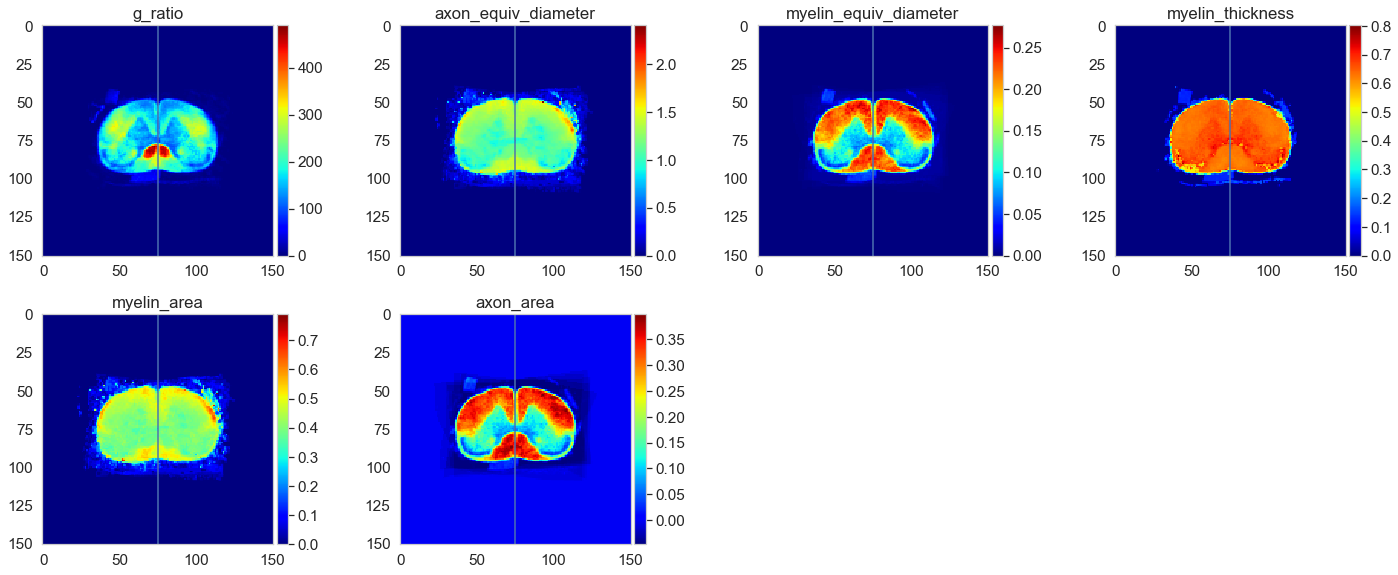

In [11]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, data.shape[2]+1):
    ax = fig.add_subplot(5, 4, i)
    img = ax.imshow(data[..., i-1], cmap="jet")
    # Center line
    ax.axvline(original_shape[1] // 2) 
    plt.title(feature_names[i-1])
    colorbar(img)

plt.tight_layout(h_pad=1)

### Connectivity

In [12]:
voxvox = data.shape[0] * data.shape[1]

In [13]:
symmetry = np.zeros((voxvox, voxvox), dtype=np.int64)
rlen, clen = data.shape[0:2]

for ridx in range(rlen):
    for cidx in range(0, clen // 2):
        p1_idx = (ridx * clen) + cidx
        p2_idx = (ridx * clen) + (cidx + (clen // 2))
        symmetry[p1_idx][p2_idx] = 1
        symmetry[p2_idx][p1_idx] = 1

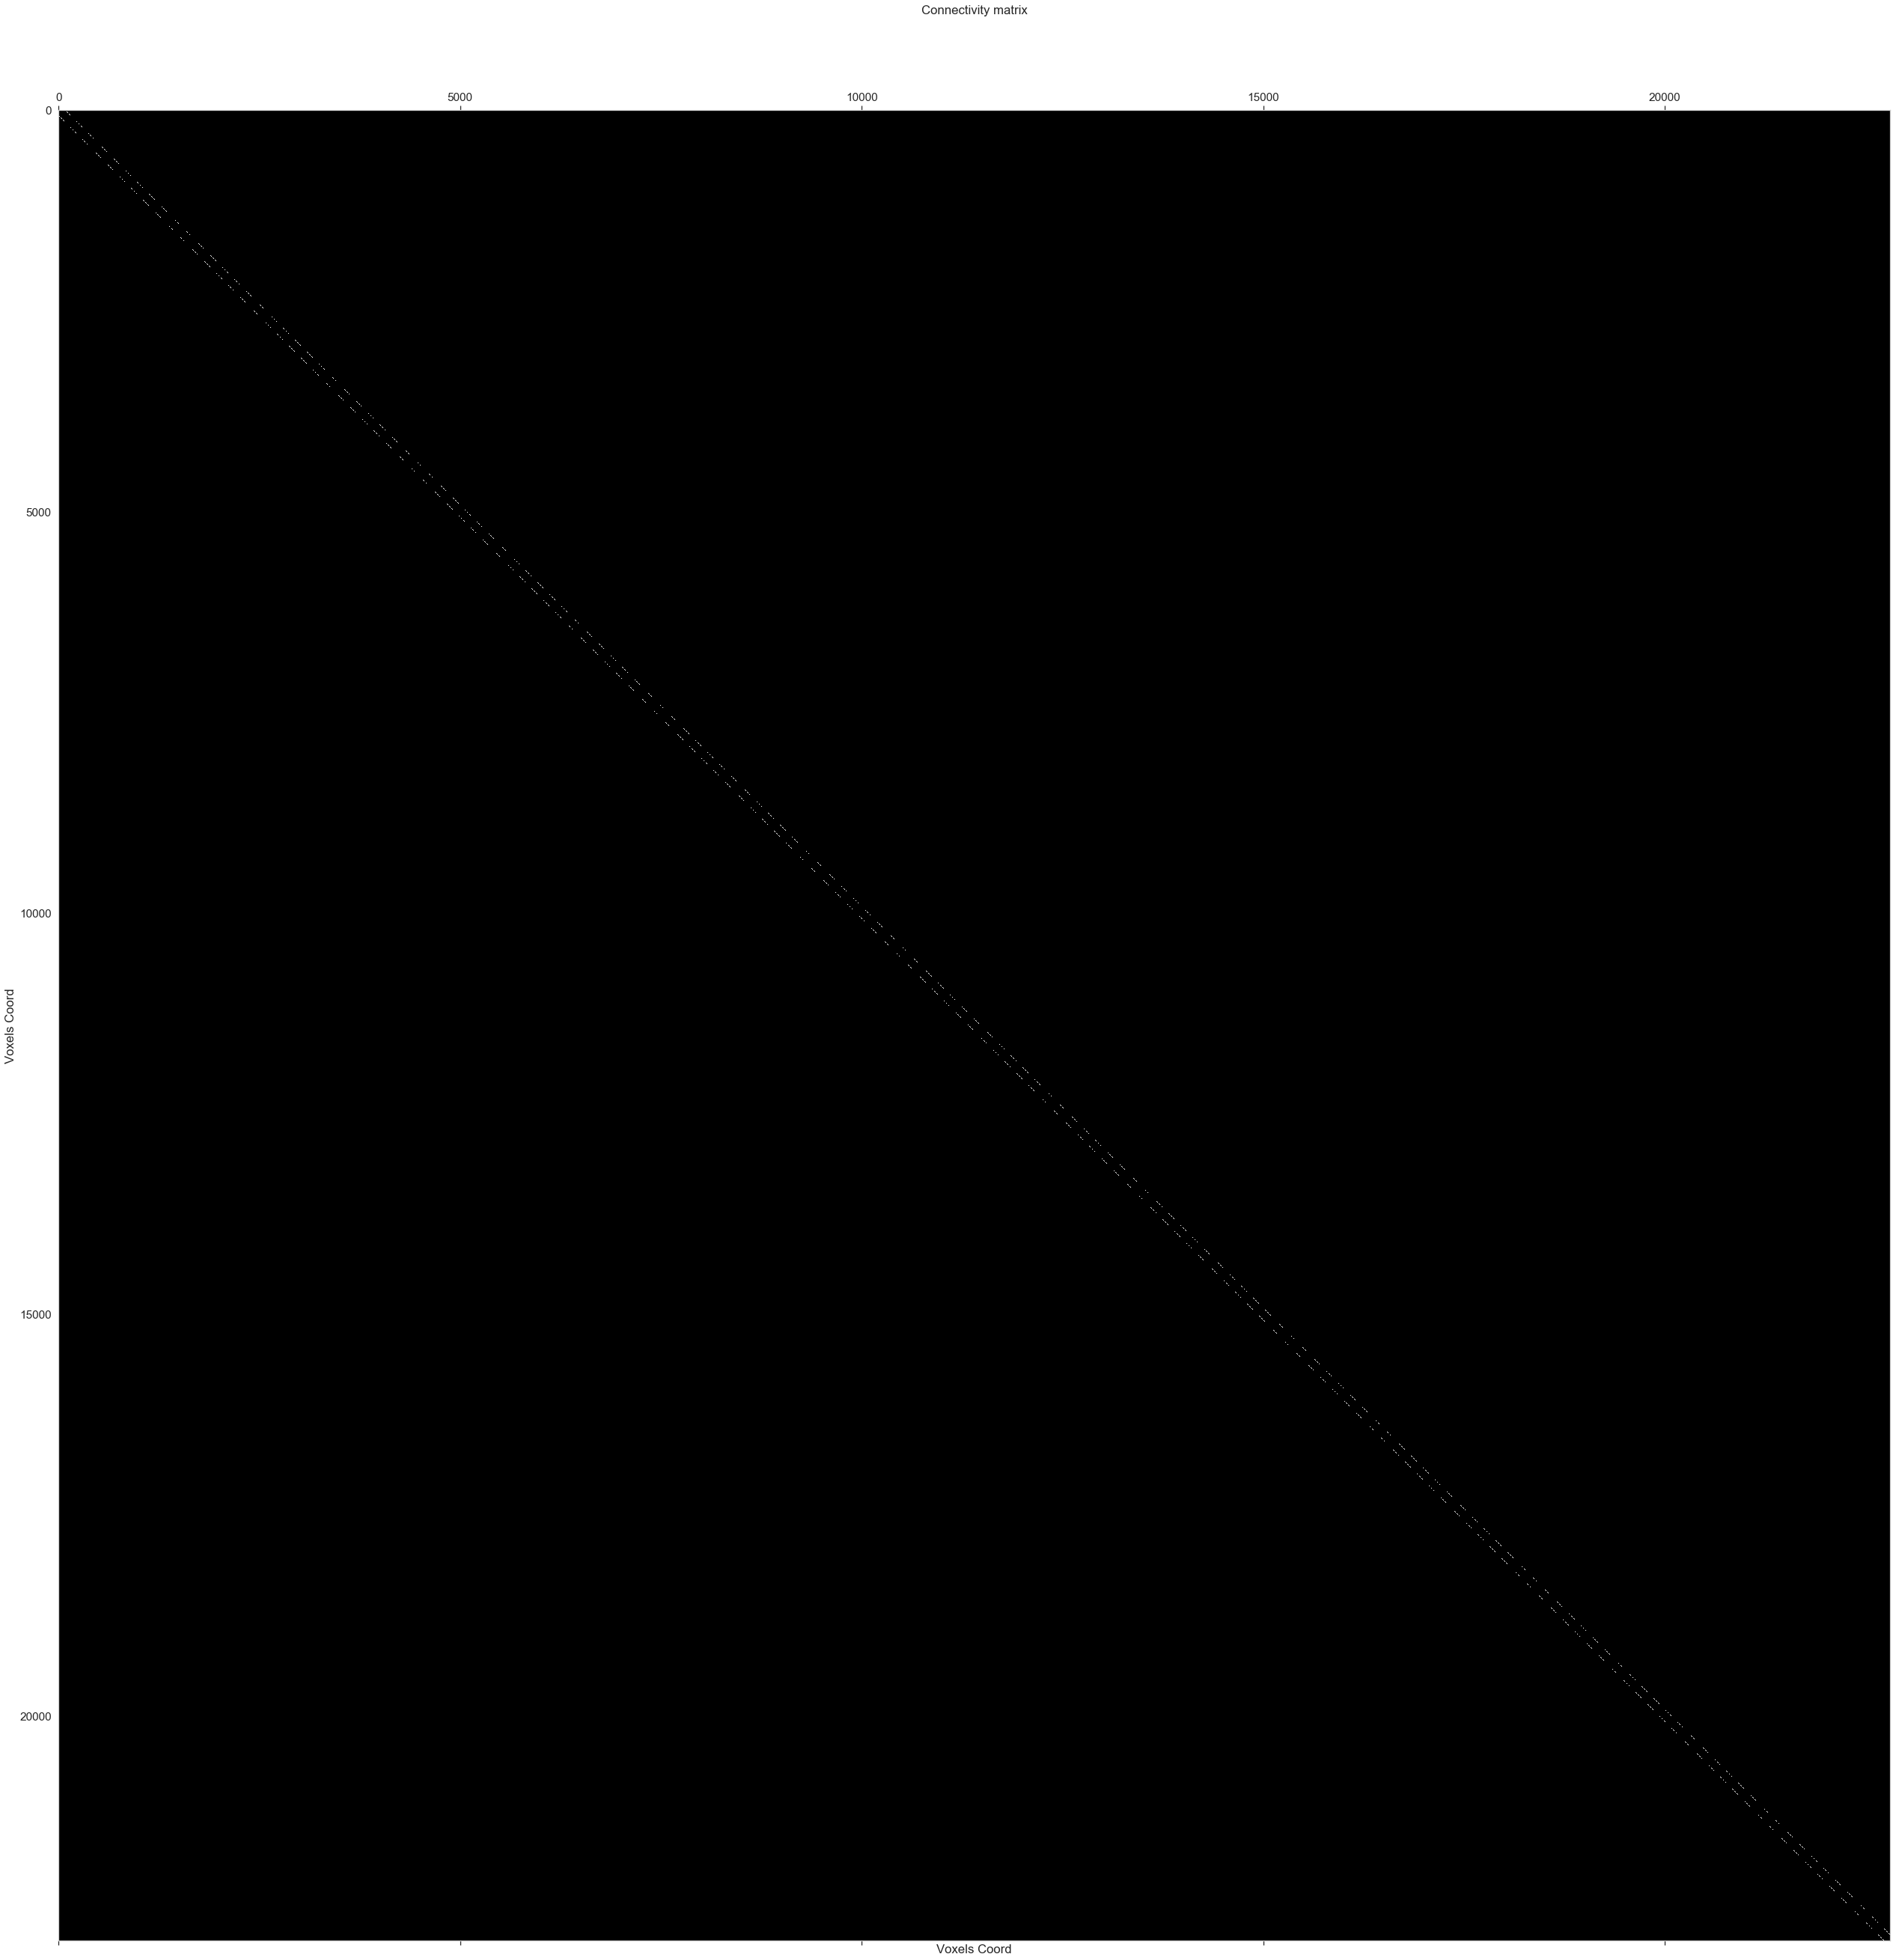

In [15]:
fig, ax = plt.subplots(figsize=(50, 45)) 
ax.matshow(symmetry, cmap="gray", interpolation="none")
ax.set_title("Connectivity matrix")
ax.set_xlabel("Voxels Coord")
ax.set_ylabel("Voxels Coord");

In [16]:
connectivity = grid_to_graph(n_x=data.shape[0],
                             n_y=data.shape[1],
                             return_as=np.ndarray)

In [17]:
data = data.reshape(-1, data.shape[2])

In [18]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [19]:
data.shape

(22801, 6)

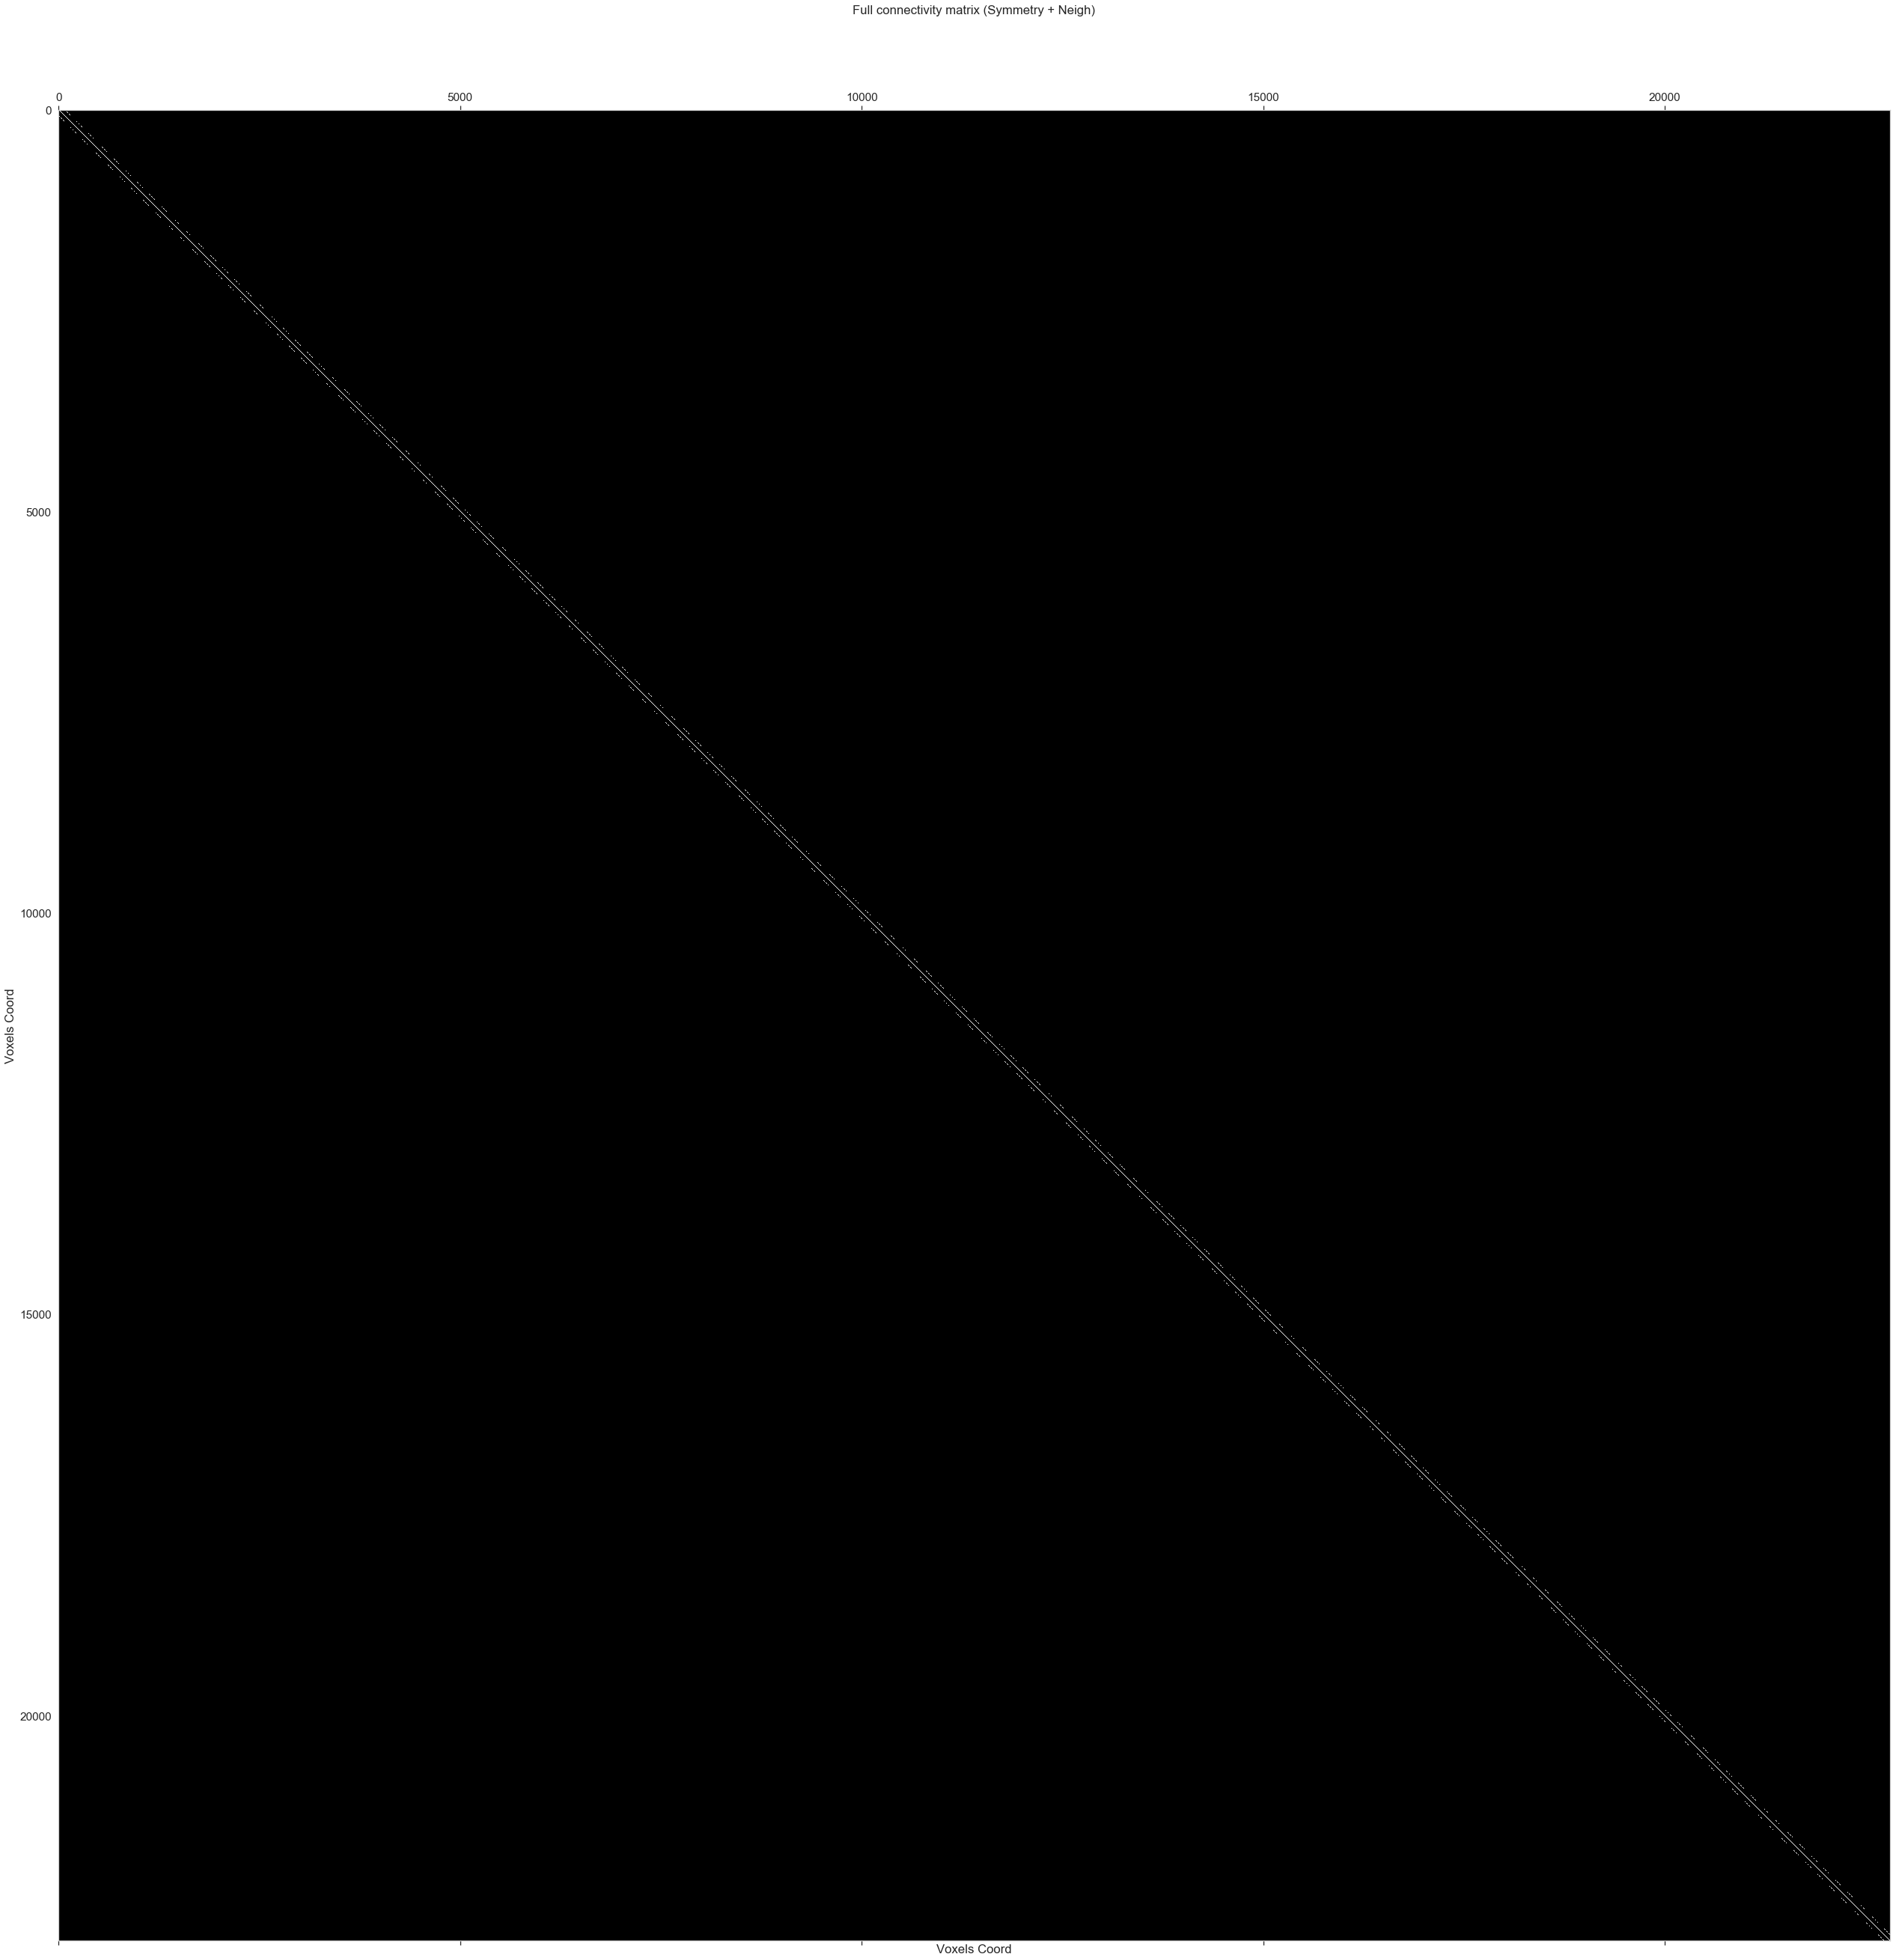

In [20]:
fig, ax = plt.subplots(figsize=(50, 45)) 
ax.matshow(connectivity+symmetry, cmap="gray", interpolation="none")
ax.set_title("Full connectivity matrix (Symmetry + Neigh)")
ax.set_xlabel("Voxels Coord")
ax.set_ylabel("Voxels Coord");

# t-SNE

In [17]:
data_embedded = TSNE(n_components=2, verbose=3, perplexity=40).fit_transform(data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3366 samples in 0.005s...
[t-SNE] Computed neighbors for 3366 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3366
[t-SNE] Computed conditional probabilities for sample 2000 / 3366
[t-SNE] Computed conditional probabilities for sample 3000 / 3366
[t-SNE] Computed conditional probabilities for sample 3366 / 3366
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.259s
[t-SNE] Iteration 50: error = 66.7639694, gradient norm = 0.1855635 (50 iterations in 6.169s)
[t-SNE] Iteration 100: error = 58.3520775, gradient norm = 0.1344338 (50 iterations in 4.695s)
[t-SNE] Iteration 150: error = 56.2108231, gradient norm = 0.1330982 (50 iterations in 4.599s)
[t-SNE] Iteration 200: error = 55.7240219, gradient norm = 0.1031496 (50 iterations in 5.023s)
[t-SNE] Iteration 250: error = 55.3906555, gradient norm = 0.0800254 (50 iterations in 5.659s)
[t-SNE] KL divergence after 250 iterat

In [21]:
num_clusters = 15
clustering = AgglomerativeClustering(linkage="ward", n_clusters=num_clusters,
                                     connectivity=connectivity)
clustering.fit(data)
labels = clustering.labels_

In [22]:
labels = labels.reshape(*original_shape)

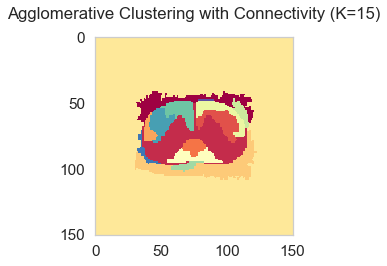

In [23]:
plt.imshow(labels, cmap="Spectral")
plt.title("Agglomerative Clustering with Connectivity (K={})".format(num_clusters), pad=18)
plt.tight_layout()

In [24]:
plt.figure(figsize=(12, 8))
plt.scatter(data_embedded[:, 0], data_embedded[:, 1],
            cmap="Spectral", s=10, c=clustering.labels_)
plt.title("t-SNE without spatial information")
plt.show()

NameError: name 'data_embedded' is not defined

<Figure size 864x576 with 0 Axes>

### Clustering with adjacency connectivity matrix

0.83867127
0.76527995
0.75745803
0.7571769
0.757537
0.75682646
0.7537992
0.75330234
0.7505702
0.7465115
0.73901963
0.7372374
0.73926735
0.735982
0.732757
0.71529096
0.7107541
0.71321905
0.71451104
0.7130132
0.71276027
0.71091753
0.7109873
0.7124268
0.71194303


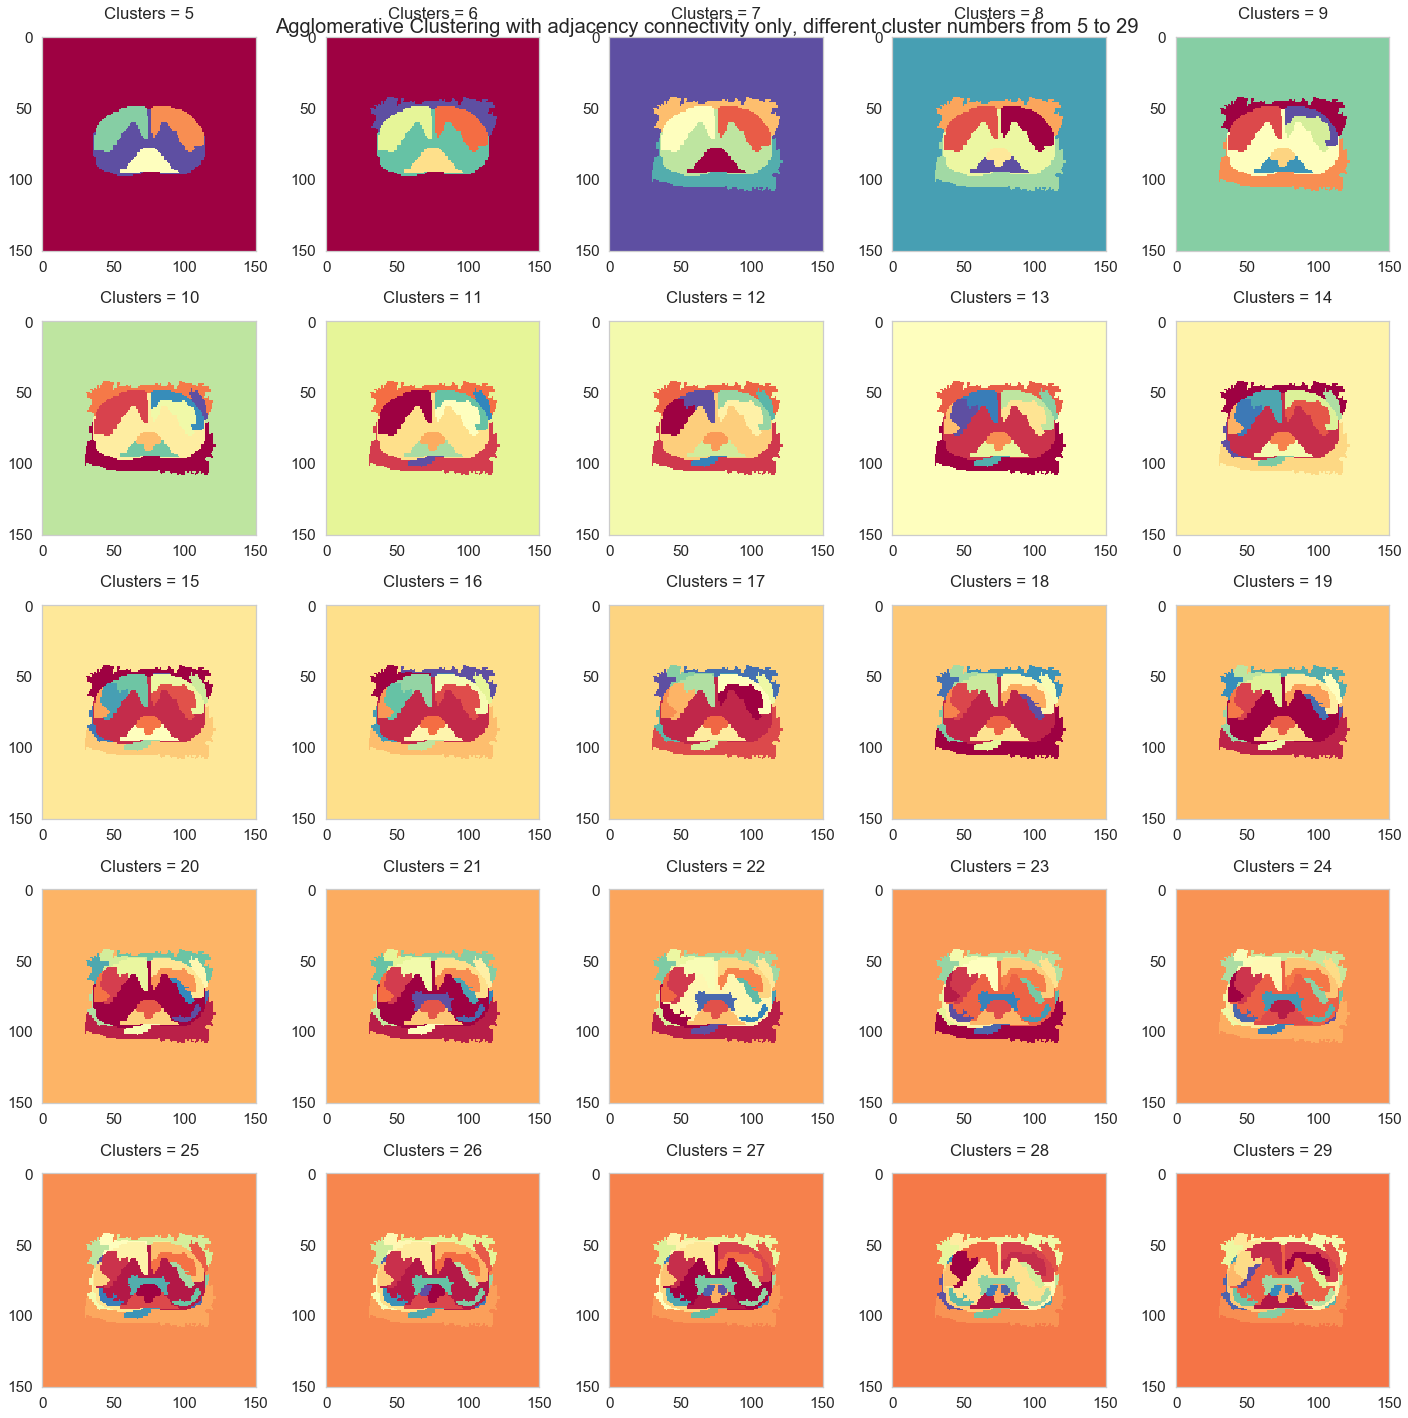

In [27]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 26):
    clustering = AgglomerativeClustering(linkage="ward", n_clusters=i+4,
                                         connectivity=connectivity)
    clustering.fit(data)
    labels = clustering.labels_
    silhouette= silhouette_score(data, labels)
    print silhouette
    
    labels = labels.reshape(*original_shape)

    ax = fig.add_subplot(5, 5, i)
    img = ax.imshow(labels, cmap="Spectral")
    plt.title("Clusters = {}".format(i+4), pad=18)
    plt.tight_layout()

plt.suptitle("Agglomerative Clustering with adjacency connectivity only, different cluster numbers from 5 to 29")
plt.tight_layout(h_pad=1)

### Clustering with symmetry connectivity + adjacency matrix

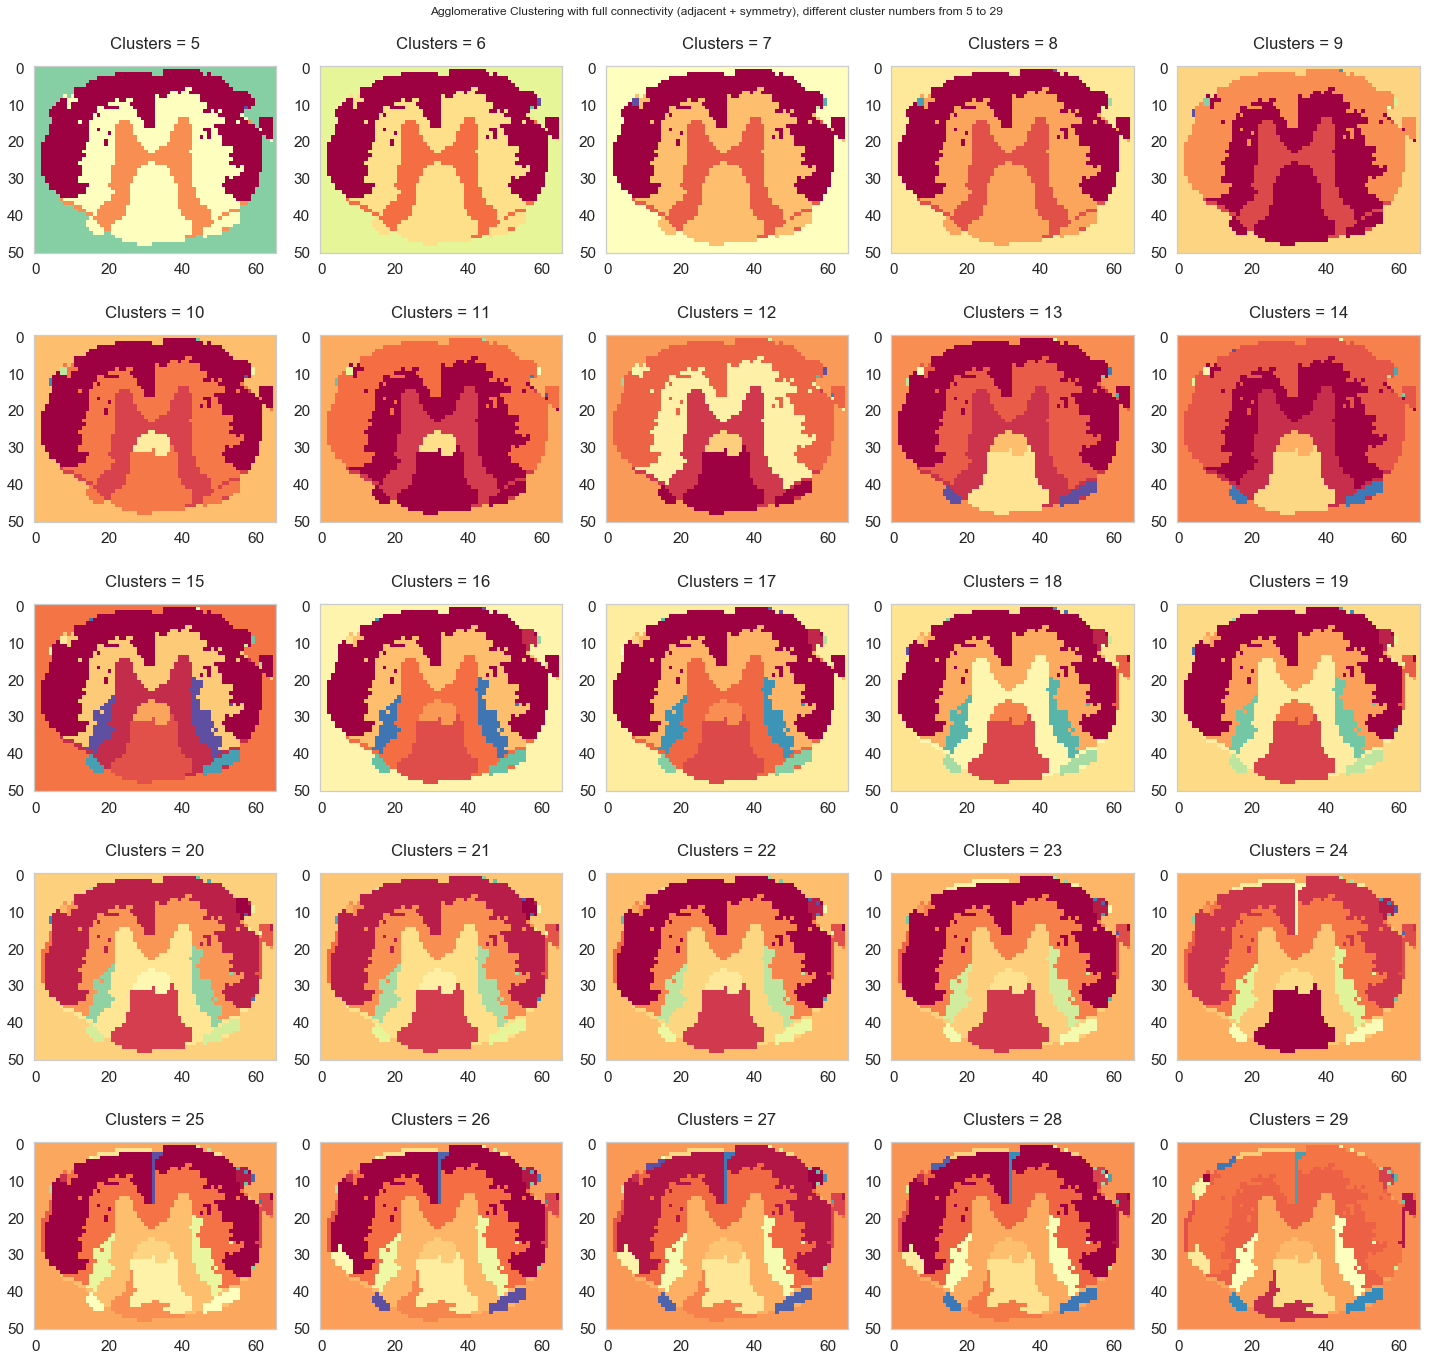

In [25]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 26):
    clustering = AgglomerativeClustering(linkage="ward", n_clusters=i+4,
                                         connectivity=connectivity+symmetry)
    clustering.fit(data)
    labels = clustering.labels_
    labels = labels.reshape(*original_shape)

    ax = fig.add_subplot(5, 5, i)
    img = ax.imshow(labels, cmap="Spectral")
    plt.title("Clusters = {}".format(i+4), pad=18)
    plt.tight_layout()

plt.suptitle("Agglomerative Clustering with full connectivity (adjacent + symmetry), different cluster numbers from 5 to 29")
plt.tight_layout(h_pad=1)